In [1]:
pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25837 sha256=e7bb8ead84b7f27e93ab5404a2e3c414ec7738bb2b0f71bf8cbb0d3995c92ee0
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


# Malaria Cell Images Dataset
# # Author: Eren ERİŞ
**Resim Sınıflandırma Problemi**

In [2]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random , os , glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

#warningleri kapatmak için
import warnings
warnings.filterwarnings('ignore')

#Model değerleendirmek için kullanılacak kütüphane
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.model_selection import train_test_split
#Model İçin Kullanılacak Kütüphaneler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D , Flatten , MaxPooling2D , Dense , Dropout , SpatialDropout2D , Input , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator , img_to_array , load_img , array_to_img

from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [3]:
#Target Size 
target_size = (142,142)

In [4]:
def load_datasets(path,category):
    x = []
    labels = []
    image_paths = sorted(list(paths.list_images(path)))
    for image_path in image_paths:
        #Belirtilen Görüntüleri Open CV İle Oku
        img = cv2.imread(image_path)

        #Okunan görüntüleri başlangıçta belirlenen target_sizea göre yeniden ölçeklendir
        img = cv2.resize(img , target_size)

        #ölçeklendirilen görüntüyü x listesine ekle
        x.append(img)

        #Dosya okuma yapılırken labels degiskenide gönderildi
        labels.append(category)
    return x, labels

In [5]:
x1,labels1 = load_datasets("/kaggle/input/cell-images-for-detecting-malaria/cell_images/Parasitized","Parasitized")
x2,labels2 = load_datasets("/kaggle/input/cell-images-for-detecting-malaria/cell_images/Uninfected","Uninfected")

In [6]:
def visualize_img(image_batch , label_batch):
  plt.figure(figsize=(10,10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(label_batch)
    plt.axis("off")

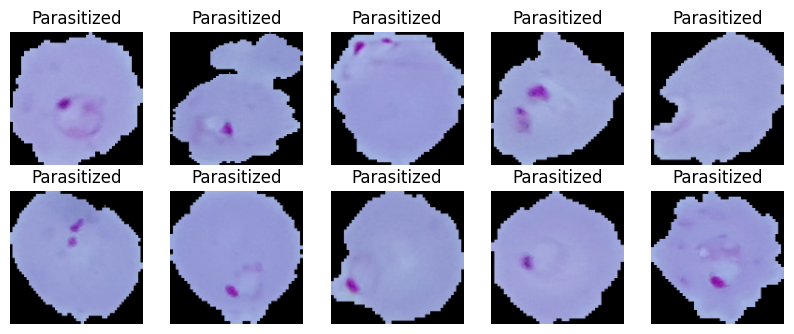

In [7]:
# Parasitized Data Random Show
visualize_img(x1 , "Parasitized")

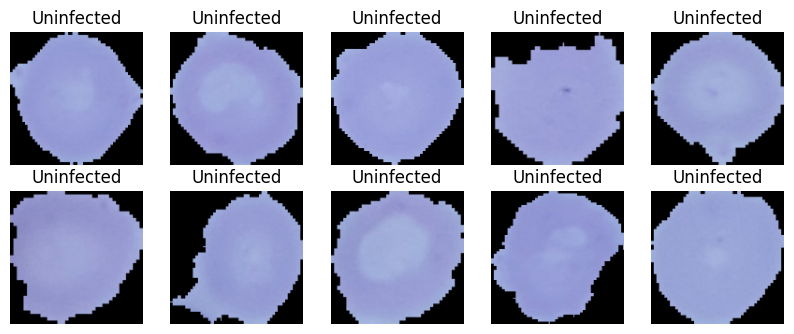

In [8]:
# Uninfected Data Random Show
visualize_img(x2 , "Uninfected")

In [9]:
# x1 ve labels1 ile x2 ve labels2'yi concat
x = np.concatenate((x1, x2), axis=0)
labels= np.concatenate((labels1, labels2), axis=0)

# Random Shuffle Data
random_indices = np.random.permutation(len(x))
x = x[random_indices]
labels = labels[random_indices]

In [10]:
def random_visualize_img(image_batch , label_batch):
  plt.figure(figsize=(10,10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n])
    plt.axis("off")

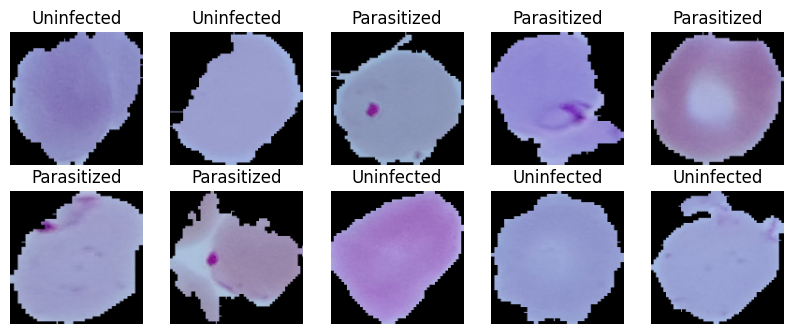

In [11]:
random_visualize_img(x , labels)

In [12]:
input_shape = (np.array(x[0]).shape[1],np.array(x[0]).shape[1],3)
print(input_shape)

(142, 142, 3)


In [13]:
# Assuming 'labels' contains string labels like 'Parasitized', 'Uninfected'
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert the integer labels to one-hot encoded format
labels_cat = to_categorical(labels_encoded, num_classes=2)

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(x, labels_cat, test_size=0.33, shuffle=True)

In [14]:
#Modelin Kurulması
from keras.api._v2.keras import activations
model = Sequential()
model.add(Input(input_shape))
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))

model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))

model.add(Flatten())

model.add(Dense(units=512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))


model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.2))


model.add(Dense(units=2, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 142, 142, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 71, 71, 32)        128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 71, 71, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 35, 35, 32)        0

In [16]:

#Optimasyon Metriklerin Ayarlanması

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),"acc"])


In [17]:
callbacks = [EarlyStopping(monitor='val_loss',patience=50,verbose=1,mode="min"),
             ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss',mode='min',save_best_only=True,save_weights_only=False,verbose=1)]

In [18]:
# Modeli eğitme
history = model.fit(np.array(x_train),y_train, batch_size = 64,
                   verbose = 1,
                   epochs = 50,
                   validation_split = 0.1,
                   shuffle = False)

Epoch 1/50
260/260 [==============================] - 321s 1s/step - loss: 0.5672 - precision: 0.7369 - recall: 0.7369 - acc: 0.7369 - val_loss: 3.3224 - val_precision: 0.5555 - val_recall: 0.5555 - val_acc: 0.5555
Epoch 2/50
260/260 [==============================] - 322s 1s/step - loss: 0.2475 - precision: 0.9067 - recall: 0.9067 - acc: 0.9067 - val_loss: 1.5504 - val_precision: 0.7607 - val_recall: 0.7607 - val_acc: 0.7607
Epoch 3/50
260/260 [==============================] - 321s 1s/step - loss: 0.1972 - precision: 0.9302 - recall: 0.9302 - acc: 0.9302 - val_loss: 0.2329 - val_precision: 0.9134 - val_recall: 0.9134 - val_acc: 0.9134
Epoch 4/50
260/260 [==============================] - 322s 1s/step - loss: 0.1643 - precision: 0.9400 - recall: 0.9400 - acc: 0.9400 - val_loss: 0.2643 - val_precision: 0.9150 - val_recall: 0.9150 - val_acc: 0.9150
Epoch 5/50
260/260 [==============================] - 321s 1s/step - loss: 0.1356 - precision: 0.9508 - recall: 0.9508 - acc: 0.9508 - val_l

Text(0.5, 1.0, 'Training and Validation Loss')

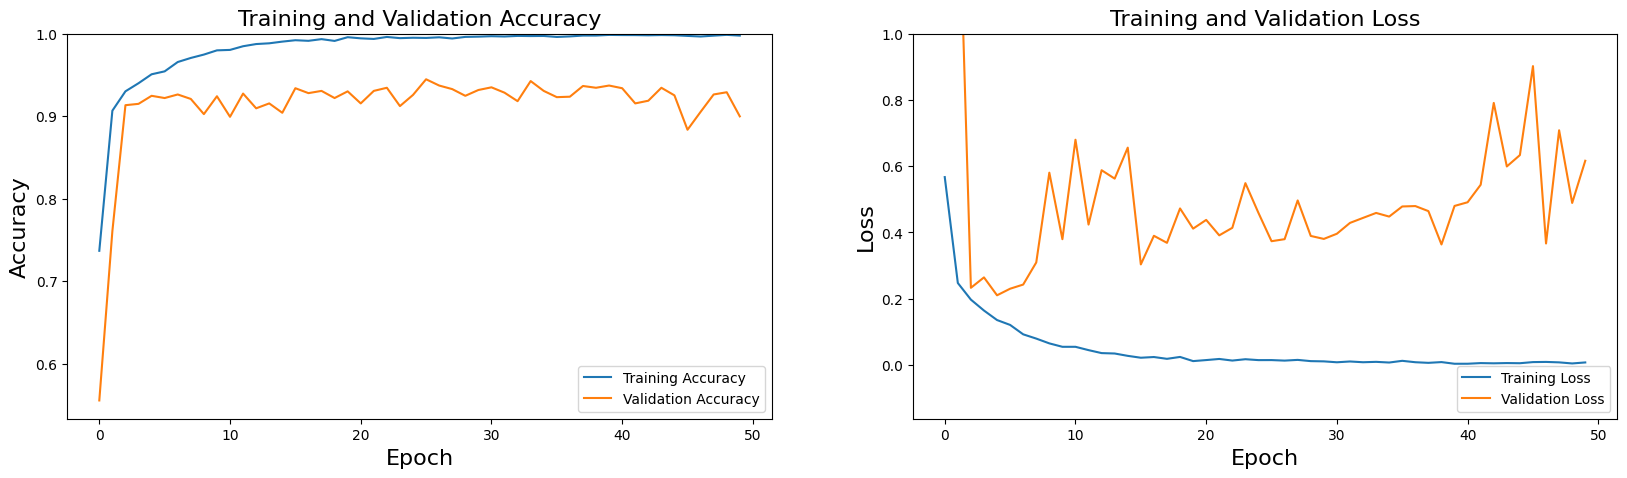

In [19]:
#------------------------
#Accuracy Grafik
#------------------------

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'],label='Training Accuracy')
plt.plot(history.history['val_acc'],label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontsize=16)


#------------------------
#Loss Grafik
#------------------------

plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='lower right')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss',fontsize=16)

In [24]:
#Test verisi için generator Tanımlama
test = ImageDataGenerator(rescale=1/255,
                          validation_split=0.1)

test_generator = test.flow_from_directory(
    directory="/kaggle/input/cell-images-for-detecting-malaria/cell_images",
    target_size=(target_size),
    batch_size=251,
    class_mode='categorical',
    subset='validation'
)

Found 5509 images belonging to 3 classes.


In [25]:
loss,precision , recall,acc = model.evaluate(test_generator,batch_size=32)

print("\nTest accuracy: %.1f%%" %(100.0*acc)) # Doğru Sınıflandırma Oranı
print("\nTest loss: %.1f%%" %(100.0*loss))
print("\nTest precision: %.1f%%" %(100.0*precision)) #Tahmin Edilenlerin Ne kadar Başarılı Olduğu
print("\nTest recall: %.1f%%" %(100.0*recall)) # gercek Değerleri Ne kadar doğru tahmin ettik

InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_42/426877275.py", line 1, in <module>
      loss,precision , recall,acc = model.evaluate(test_generator,batch_size=32)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2200, in evaluate
      logs = test_function_runner.run_step(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 4000, in run_step
      tmp_logs = self._function(dataset_or_iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1972, in test_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1956, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1944, in run_step
      outputs = model.test_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1852, in test_step
      self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/losses.py", line 2122, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/opt/conda/lib/python3.10/site-packages/keras/src/backend.py", line 5566, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[251,2] labels_size=[251,3]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_test_function_94615]

In [28]:
#Classification Report
x_test , y_test = test_generator.next()

y_pred = model.predict(x_test);

y_pred = np.argmax(y_pred,axis=1)
y_test = np.argmax(y_test,axis=1)



print(classification_report(y_test,y_pred))

8/8 [==============================] - 1s 132ms/step
              precision    recall  f1-score   support

           0       0.26      1.00      0.42        66
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00       124

    accuracy                           0.26       251
   macro avg       0.09      0.33      0.14       251
weighted avg       0.07      0.26      0.11       251

